## Laboratorio #1 – Detección de Pishing

### Parte 1 – Ingeniería de características

In [28]:
##Importancion de librerias
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

In [2]:
## carga de datos
df = pd.read_csv("dataset_pishing.csv", sep = ",")

In [3]:
type(df)

pandas.core.frame.DataFrame

In [5]:
## verificacion de estructura de la data
n = int(input("Ingrese las filas que desea ver"))
df.head(n)

,url,status
0,http://www.crestonwood.com/router.php,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,phishing
2,https://support-appleld.com.secureupdate.duila...,phishing
3,http://rgipt.ac.in,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,legitimate
5,http://appleid.apple.com-app.es/,phishing
6,http://www.mutuo.it,legitimate
7,http://www.shadetreetechnology.com/V4/validati...,phishing
8,http://vamoaestudiarmedicina.blogspot.com/,legitimate
9,https://parade.com/425836/joshwigler/the-amazi...,legitimate


Teniendo en cuenta lo anterior parece que el dataset no se encuentra balanceado.

### Derivación de características

¿Qué ventajas tiene el análisis de una URL contra el análisis de otros datos, cómo el tiempo
de vida del dominio, o las características de la página Web?

En base al análisis de otros datos, como el es el tiempo de vida del domino el cual ha sido registrado recientemente, podría ser una señal de alerta, ya que los sitios de pishing tienden a ser temporales

Analizar una URL es rápido ya que solo es texto, mientras que al analizar la página completa o verificar el historial de dominio puede requerir más recursos y acceso a bases de datos externos, igualmente algunas páginas pueden bloquear el acceso de scarpers o herramientas de análisis, pero la URL se puede analizar sin necesidad de entrar al sitio web.

¿Qué características de una URL son más prometedoras para la detección de phishing?

El análisis de una URL es una herramienta efectiva para detectar sitios de phishing, ya que su estructura puede revelar patrones sospechosos sin necesidad de acceder al contenido de la página. 

- Los sitios de phishing suelen imitar dominios legítimos agregando palabras clave reconocidas como "login", "secure", "bank" etc.

- URLs que incluyen símbolos como @, %, -, _ en posiciones extrañas pueden estar tratando de ocultar su verdadero dominio.

- URLs con múltiples subdirectorios anidados pueden ser indicativas de una estructura diseñada para engañar al usuario.

- URLs extremadamente largas pueden ser un intento de ocultar información maliciosa dentro de parámetros.

### Funciones para extraer características de una URL

- Entropía de Shannon
    - Calcula la entropía de la URL para medir qué tan aleatoria es.
    - URLs generadas aleatoriamente suelen tener alta entropía.

- Entropía relativa
    - Normaliza la entropía de Shannon respecto a la longitud de la URL.
    - URLs de phishing tienden a ser más caóticas que las legítimas.

- Longitud total de la URL
    - Calcula la cantidad total de caracteres en la URL.
    - URLs largas suelen ser sospechosas.

- Número de subdominios
    - Cuenta los subdominios en la URL (separados por puntos .).
    - Un número alto puede indicar phishing (login.secure.paypal.com).

- Número de caracteres especiales en la URL
    - Cuenta símbolos como -, _, /, @, ?, &, =.
    - Phishers suelen incluir caracteres adicionales para disfrazar la URL.

- Número de números en la URL
    - Cuenta los dígitos en la URL.
    - Los dominios legítimos rara vez incluyen números arbitrarios.

- Número de palabras en el dominio
    - Separa la parte del dominio y cuenta cuántas palabras contiene.

- Presencia de palabras clave sospechosas
    - Busca palabras como login, secure, account, update, verify, free, gift.
    - Estas palabras son comunes en URLs de phishing.

- Comparación con dominios de marca (Typosquatting)
    - Calcula la distancia de Levenshtein entre la URL y nombres de dominio conocidos (g00gle.com vs. google.com).
    - Detecta cambios sutiles que engañan a los usuarios.

- Verificación de dominio en Alexa Top 1M
    - Si el dominio está en el ranking de sitios más visitados, es menos probable que sea phishing.

- Uso de TLD sospechoso
    - Evalúa si el dominio tiene una extensión de alto riesgo (.tk, .ml, .cf, .ga, .gq).
    - Los atacantes suelen usar estos TLDs gratuitos.

- Número de directorios en el path
    - Cuenta cuántas barras / hay en la URL (http://example.com/a/b/c/login.php).
    - Un número alto puede indicar estructuras complejas usadas en phishing.

- Uso de Punycode
    - Verifica si la URL usa codificación Punycode (xn--paypal-login-xyz.com).
    - Puede ser un intento de disfrazar caracteres Unicode.

- Verificación de HTTP vs. HTTPS
    - Evalúa si la URL usa http en lugar de https.
    - Un sitio de phishing puede no tener certificado SSL válido.

- Presencia de una dirección IP en lugar de dominio
    - Si la URL contiene una dirección IP (http://192.168.1.1/login), es sospechosa.






### Preprocesamiento

In [ ]:
# convertir la variable 'status' a binaria (1 = phishing, 0 = legitimate)
df['status'] = df['status'].map({'phishing': 1, 'legitimate': 0})

In [7]:

df['url'] = df['url'].str.lower().str.strip()  # Convertir a minúsculas y eliminar espacios innecesarios

In [8]:
# Verificación de estructura de la data
n = int(input("Ingrese las filas que desea ver: "))
print(df.head(n))

                                                 url  status
0              http://www.crestonwood.com/router.php       0
1  http://shadetreetechnology.com/v4/validation/a...       1
2  https://support-appleld.com.secureupdate.duila...       1
3                                 http://rgipt.ac.in       0
4  http://www.iracing.com/tracks/gateway-motorspo...       0
5                   http://appleid.apple.com-app.es/       1
6                                http://www.mutuo.it       0
7  http://www.shadetreetechnology.com/v4/validati...       1
8         http://vamoaestudiarmedicina.blogspot.com/       0
9  https://parade.com/425836/joshwigler/the-amazi...       0


In [9]:
# Guardar el dataset limpio
df.to_csv("dataset_preprocesado.csv", index=False)

El dataset proporcionado solamente contaba con la columna URL y Status por lo cual ambas son necesarias para proceder con la implementación.

## Implementación

In [11]:
# dataset preprocesado
df = pd.read_csv("dataset_preprocesado.csv")

In [12]:
# Separar la columna objetivo - status y la de características - url
X = df['url']  # Característica
y = df['status']  # Etiqueta binaria

In [13]:
# Separar datos de entrenamiento (55%) y conjunto auxiliar (45%)
X_train, X_aux, y_train, y_aux = train_test_split(X, y, test_size=0.45, random_state=42, stratify=y)

In [14]:
# datos de validación 15% y prueba 30% desde el conjunto auxiliar
X_val, X_test, y_val, y_test = train_test_split(X_aux, y_aux, test_size=0.6667, random_state=42, stratify=y_aux)

In [15]:
# Convertir a DataFrames
train_df = pd.DataFrame({'url': X_train, 'status': y_train})
val_df = pd.DataFrame({'url': X_val, 'status': y_val})
test_df = pd.DataFrame({'url': X_test, 'status': y_test})

In [16]:
# Guardar en archivos CSV
train_df.to_csv("train.csv", index=False)
val_df.to_csv("validation.csv", index=False)
test_df.to_csv("test.csv", index=False)

# Modelos

## SVM

Se escogió para realizar la clasificación ya que maneja bien los datos de alta dimensionalidad cuando se aplican transformaciones a las URLs. 

Funciona bien con datasets pequeños y medianos, aunque puede ser costoso computacionalmente con datos muy grandes.

In [18]:
# Cargar los datasets
train_df = pd.read_csv("train.csv")
val_df = pd.read_csv("validation.csv")
test_df = pd.read_csv("test.csv")

In [19]:
# Separar características X y etiquetas Y
X_train, y_train = train_df['url'], train_df['status']
X_val, y_val = val_df['url'], val_df['status']
X_test, y_test = test_df['url'], test_df['status']

Convertir las URLs en características numéricas, usando TF-IDF (como en CANTINA).


In [20]:
# Convertir URLs en características numéricas con TF-IDF
vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(2, 5))  # Usa n-gramas de caracteres
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)


In [21]:
# Definir modelo SVM
svm_model = SVC(kernel='linear', probability=True, random_state=42)


Entrenar un modelo SVM con el conjunto de entrenamiento.

In [22]:
# Entrenar modelo SVM
svm_model.fit(X_train_tfidf, y_train)


SVC(kernel='linear', probability=True, random_state=42)

In [23]:
# Evaluar en validación
y_val_pred = svm_model.predict(X_val_tfidf)
y_val_prob = svm_model.predict_proba(X_val_tfidf)[:, 1]

In [24]:
# Evaluar en prueba
y_test_pred = svm_model.predict(X_test_tfidf)
y_test_prob = svm_model.predict_proba(X_test_tfidf)[:, 1]

### Resultados del entrenamiento

In [25]:
# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_test_pred)

In [26]:
# Reporte de clasificación
class_report = classification_report(y_test, y_test_pred, target_names=['Legitimate', 'Phishing'])

In [27]:
# Curva ROC y AUC
fpr, tpr, _ = roc_curve(y_test, y_test_prob)
roc_auc = auc(fpr, tpr)

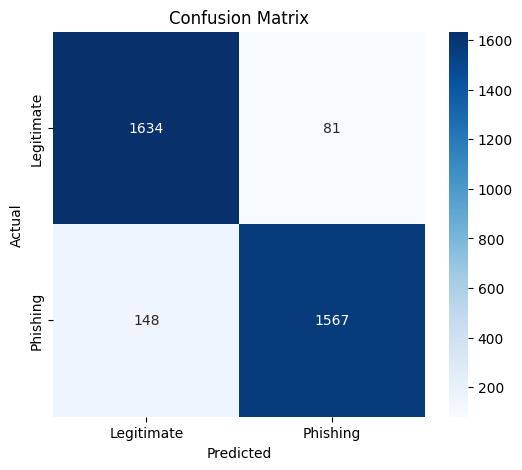

In [29]:
# Graficar Matriz de Confusión
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=['Legitimate', 'Phishing'], yticklabels=['Legitimate', 'Phishing'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Resultados de la matriz de confusión: 
- Verdaderos positivos (Phishing detectado correctamente): 1567
- Verdaderos negativos (Legitimate detectado correctamente): 1634
- Falsos positivos (Legitimate clasificado como Phishing): 81
- Falsos negativos (Phishing clasificado como Legitimate): 148


Los 148 falsos negativos significan que el modelo no detectó 148 sitios de phishing, lo cual puede ser peligroso en un entorno real. En un caso de seguridad, un FN es más crítico que un FP, porque significa que un usuario podría confiar en un sitio malicioso.

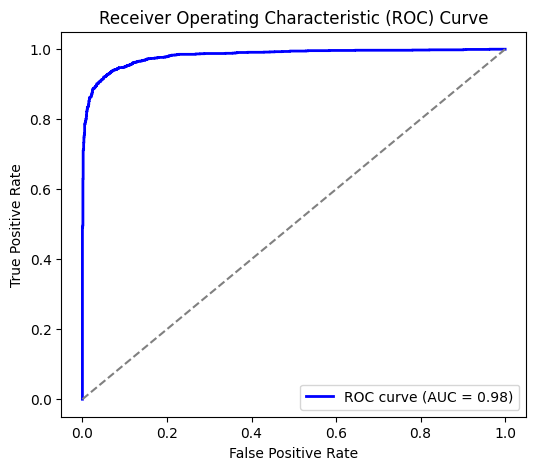

In [30]:
# Graficar Curva ROC
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [31]:
# Imprimir métricas
print("Classification Report:\n", class_report)
print(f"Area Under Curve (AUC): {roc_auc:.4f}")


Classification Report:
               precision    recall  f1-score   support

  Legitimate       0.92      0.95      0.93      1715
    Phishing       0.95      0.91      0.93      1715

    accuracy                           0.93      3430
   macro avg       0.93      0.93      0.93      3430
weighted avg       0.93      0.93      0.93      3430

Area Under Curve (AUC): 0.9818


Le fue bastante bien al modelo, con un AUC de  0.9818 y una precisión y recall equilibrados en 0.93, el SVM parece estar funcionando bien en general. Por lo que se comento anteriormente con el FN el cual en consideración del tema es elevado, se recomienda  bajar el umbral para que el modelo sea más sensible al phishing, reduciendo falsos negativos a costa de aumentar falsos positivos.

## Discusión

4. ¿Cuál es el impacto de clasificar un sitio legítimo como phishing?


5. ¿Cuál es el impacto de clasificar un sitio de phishing como legítimo?


6. En base a las respuestas anteriores, ¿Qué métrica elegiría para comparar modelos similares de clasificación de phishing?


7. ¿Qué modelo funcionó mejor para la clasificación de phishing? ¿Por qué?

8. Una empresa desea utilizar su mejor modelo, debido a que sus empleados sufren constantes ataques de phishing mediante e-mail. La empresa estima que, de un total de 50,000 emails, un 15% son phishing. ¿Qué cantidad de alarmas generaría su modelo? ¿Cuántas positivas y cuantas negativas? ¿Funciona el modelo para el BR propuesto? En caso negativo, ¿qué propone para reducir la cantidad de falsas alarmas?